## Neural Networks: Multilayer Perceptron (MLP)

### Practical task

Bronwyn Bowles-King

### Introduction

This notebook demonstrates how to build, train, and evaluate a multilayer perceptron (MLP) neural network using the FashionMNIST dataset with PyTorch. FashionMNIST has grayscale images of 10 different types of clothing. MLPs are suitable for this type of classification task.

The notebook includes data preprocessing, model definition, training with different learning rates, and performance evaluation using a confusion matrix and classification metrics. By experimenting with learning rates and analysing class-wise results, this exercise highlights the importance of model tuning and error analysis. 

### 0. Import packages

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### 1. Set random seeds

In [2]:
np.random.seed(123)
torch.manual_seed(123)

### 2. Define a class for MLP and a function for model evaluation

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 128), 
            nn.ReLU(),              # Layer 1
            nn.Dropout(p=0.2),      # Dropout regularisation 
            nn.Linear(128, 64),     # 128 and 64 units
            nn.ReLU(),              # Layer 2
            nn.Dropout(p=0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)


def evaluate_model(model, test_loader): 
    model.eval() 
    all_preds = [] 
    all_labels = [] 

    with torch.no_grad(): 
        for inputs, labels in test_loader: 
            outputs = model(inputs) 
            _, preds = torch.max(outputs, 1) 
            all_preds.extend(preds.tolist()) 
            all_labels.extend(labels.tolist()) 
        
        return all_preds, all_labels

### 3. Define transformation and load dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten dataset
])

fashion_data = FashionMNIST(root='./data', train=True, download=True, transform=transform)

### 4. Split into training and test sets

In [5]:
train_size = int(0.8 * len(fashion_data))  # 80% training
test_size = len(fashion_data) - train_size  # 20% test

train_subset, test_subset = random_split(fashion_data, [train_size, test_size], generator=torch.Generator())

# Wrap with DataLoader for batch processing
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

### 5. Run baseline MLP

#### 5.1 Set up baseline loss function and optimiser and run training

This training runs for 10 epochs, printing the loss for every two epochs.

In [6]:
mlp_1 = MLP()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(mlp_1.parameters(), lr=0.001)

for epoch in range(1, 11):
    mlp_1.train()
    for batch_x, batch_y in train_loader:
        optimiser.zero_grad()
        logits = mlp_1(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimiser.step()

    if epoch % 2 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.4f}')


Epoch [2], Loss: 0.4040
Epoch [4], Loss: 0.3282
Epoch [6], Loss: 0.2891
Epoch [8], Loss: 0.2926
Epoch [10], Loss: 0.3088


#### 5.2 Test baseline model accuracy

In [7]:
mlp_1.eval()  # Use evaluation mode
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits = mlp_1(batch_x)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)
        y_true.extend(batch_y.cpu().numpy()) 
        y_pred.extend(preds.cpu().numpy())   

print(f'Test accuracy: {correct / total:.2%}')

Test accuracy: 88.48%


### 6. Test different learning rates

The model is performing well, but some improvements might be possible. The learning rate is one of the most important hyperparameters and will be adjusted here to see how the performance changes. When testing hyperparameters, it should be noted that slight and sometimes unexpected changes in the accuracy score are possible because of the randomness and non-linear nature of the process, even when a random seed is set.

Previously, the baseline learning rate was 0.001 and this achieved a test accuracy of 88.48% shown above. Below, a higher learning rate of 0.002 is tested for mlp_2 (twice the size of the baseline). The accuracy is now just 1% lower than the baseline at 87.48%. Thus, small changes can be made to the learning rate for this model without major effects on accuracy.  

In [8]:
mlp_2 = MLP()

optimiser = optim.Adam(mlp_2.parameters(), lr=0.002)

for epoch in range(1, 11):
    mlp_2.train()
    for batch_x, batch_y in train_loader:
        optimiser.zero_grad()
        logits = mlp_2(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimiser.step()

    if epoch % 2 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.4f}')

mlp_2.eval()  
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits = mlp_2(batch_x)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

print(f'Test accuracy: {correct / total:.2%}')

Epoch [2], Loss: 0.3200
Epoch [4], Loss: 0.2454
Epoch [6], Loss: 0.4302
Epoch [8], Loss: 0.3942
Epoch [10], Loss: 0.2460
Test accuracy: 87.47%


Next, a learning rate of 0.01 (mlp_3), which is 10 times greater than the baseline, is tested and it shows a lower accuracy of 84.32%. A step size increase to 0.01 or 0.002 can both perform reasonably well, but not as well as the baseline of 0.001.

When the learning rate was raised again to 0.1, however, the accuracy was very low at 10.35% - although this test is not shown below. The model thus performs much worse with too great a step size increase for each training iteration and it is better to keep the learning rate relatively small. 

General baseline hyperparameters such as a learning rate of 0.001 are recommended for good reason and it may not be worth the additional time and computational power to adjust and test them unnecessarily when the model is already performing well.

In [9]:
mlp_3 = MLP()

optimiser = optim.Adam(mlp_3.parameters(), lr=0.01)

for epoch in range(1, 11):
    mlp_3.train()
    for batch_x, batch_y in train_loader:
        optimiser.zero_grad()
        logits = mlp_3(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimiser.step()

    if epoch % 2 == 0:
        print(f'Epoch [{epoch}], Loss: {loss.item():.4f}')

mlp_3.eval() 
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        logits = mlp_3(batch_x)
        preds = logits.argmax(dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

print(f'Test accuracy: {correct / total:.2%}')

Epoch [2], Loss: 0.6732
Epoch [4], Loss: 0.4526
Epoch [6], Loss: 0.4338
Epoch [8], Loss: 0.4734
Epoch [10], Loss: 0.3756
Test accuracy: 84.32%


### 7. Confusion matrix

A confusion matrix is created for the baseline model (mlp_1), followed by a plot of the results, as this is easier to read. The non-zero values outside the black diagonal show how often the model was incorrect in predicting the class of clothing. Class 1 and 5 show few misclassified samples. The model does not necessarily need much more training, if any, on these clothing types to generalise well to unseen samples. 

However, the model often struggles with distinguishing between class 2, 4 and 5, likely because these are similar clothing types, such as shirts and jackets. The most difficult class to get right is class 6, as the accuracy rate is only about 60%. The model will need more training on these classes and the data used for this may need to be carefully considered.

Confusion Matrix:
[[1077    6   18   25    3    1  101    0   11    0]
 [   6 1243    2    9    3    0    3    0    2    0]
 [  17    0  900    7  132    0  102    0    4    0]
 [  51    8    8 1011   57    0   32    0    4    0]
 [   2    1   87   12 1063    0   42    0    1    0]
 [   1    0    0    0    0 1168    0   33    2   15]
 [ 176    1  102   22  124    0  769    0   13    0]
 [   0    0    0    0    0   19    0 1137    1   37]
 [   3    1    6    2    5    4    6    4 1167    0]
 [   0    0    0    0    0    3    0   43    3 1082]]


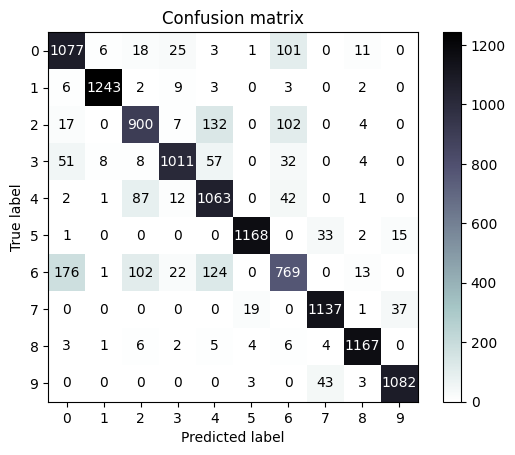

In [10]:
preds, labels = evaluate_model(mlp_1, test_loader) 
conf_matrix = confusion_matrix(labels, preds) 
print("Confusion Matrix:") 
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='bone_r')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### 8. Test model with accuracy, precision, recall and F1-scores

Precision shows out of all predictions made for a class, how many were actually correct compared to false positives. For example, the result of 0.8415 for class 0 means about 84.15% of the time it was correct, which is a very good score.

Recall measures how often the model correctly identified instances of a class compared to false negatives. The recall of 0.8293 for class 0 means the model correctly detected 82.93% of all true class 0 examples, which is again a good indication of the model's ability to predict this clothing type. We don't need to worry too much about training the model further with class 0 samples.

The F1-score is the harmonic mean of precision and recall, providing a measure that balances the difference between correct predictions and both false positives and false negatives. Class 6 has the most concerning F1-score of 0.7074 (70.74%), so it will need attention to lower the number of false predictions. 

The overall accuracy of 0.8814 means the model correctly classified 88.14% of all the samples, which is the same result calculated in section 5.2. The unweighted mean across all classes, which is the macro accuracy, and the mean for the number of samples in each class, called the weighted score, are similar to this. This shows general consistency across the model, but problematic classes (2 and 6) still need attention.

With the set performance of at least 80% achieved at this stage for the model as a whole, it is not necessary to repeat the training process, except with more samples of the classes that are difficult to classify.

In [11]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8080    0.8671    0.8365      1242
           1     0.9865    0.9803    0.9834      1268
           2     0.8014    0.7745    0.7877      1162
           3     0.9292    0.8634    0.8951      1171
           4     0.7664    0.8800    0.8193      1208
           5     0.9774    0.9582    0.9677      1219
           6     0.7289    0.6371    0.6799      1207
           7     0.9343    0.9523    0.9432      1194
           8     0.9661    0.9741    0.9701      1198
           9     0.9541    0.9567    0.9554      1131

    accuracy                         0.8848     12000
   macro avg     0.8852    0.8844    0.8838     12000
weighted avg     0.8852    0.8848    0.8840     12000



### References

Geeks for Geeks. (2025). Build the Model for Fashion MNIST dataset Using TensorFlow in Python. https://www.geeksforgeeks.org/deep-learning/build-the-model-for-fashion-mnist-dataset-using-tensorflow-in-python

HyperionDev. (2025). Build a Neural Network. Course materials. Private repository, GitHub.

HyperionDev. (2025). Neural Networks. Course materials. Private repository, GitHub.

Torch Contributors. (2017). FashionMNIST. https://docs.pytorch.org/vision/0.22/generated/torchvision.datasets.FashionMNIST.html
